In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from tqdm.notebook import tqdm

# On désactive l'import direct de DQN pour le remplacer
# from stable_baselines3 import DQN  
from stable_baselines3.common.vec_env import DummyVecEnv

# ===================================
# LIGNES AJOUTÉES pour le Double DQN 
# (Custom) 
# ===================================
import torch
import torch.nn as nn
import torch.optim as optim
from stable_baselines3.common.off_policy_algorithm import OffPolicyAlgorithm
from stable_baselines3.common.buffers import ReplayBuffer
from stable_baselines3.common.policies import BasePolicy
from stable_baselines3.common.utils import polyak_update

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
commodities = ['GC=F', 'SI=F', 'NG=F']

def get_commodities_data(tickers, start="2010-01-01", end="2023-01-01", interval="1d"):
    data = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end, interval=interval)
        data[ticker] = df
    return data

commodities_data = get_commodities_data(commodities)

# Définition des périodes
training_data_time_range = ('2010-01-01', '2017-12-31')
validation_data_time_range = ('2018-01-01', '2019-12-31')
test_data_time_range = ('2020-01-01', '2023-01-01')

training_data = {}
validation_data = {}
test_data = {}

for ticker, df in commodities_data.items():
    training_data[ticker] = df.loc[training_data_time_range[0]:training_data_time_range[1]].copy()
    validation_data[ticker] = df.loc[validation_data_time_range[0]:validation_data_time_range[1]].copy()
    test_data[ticker] = df.loc[test_data_time_range[0]:test_data_time_range[1]].copy()

print("Shapes pour GC=F (Training, Validation, Test) :", 
      training_data['GC=F'].shape, validation_data['GC=F'].shape, test_data['GC=F'].shape)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shapes pour GC=F (Training, Validation, Test) : (2011, 5) (502, 5) (756, 5)


In [3]:
def add_technical_indicators(df):
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma_tp = tp.rolling(window=20).mean()
    mean_dev = tp.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))
    df['CCI'] = (tp - sma_tp) / (0.015 * mean_dev)

    high_diff = df['High'].diff()
    low_diff = df['Low'].diff()
    df['+DM'] = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)
    df['-DM'] = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)
    tr = pd.concat([df['High'] - df['Low'], 
                    np.abs(df['High'] - df['Close'].shift(1)), 
                    np.abs(df['Low'] - df['Close'].shift(1))], axis=1).max(axis=1)
    atr = tr.ewm(span=14, adjust=False).mean()
    df['+DI'] = 100 * (df['+DM'].ewm(span=14, adjust=False).mean() / atr)
    df['-DI'] = 100 * (df['-DM'].ewm(span=14, adjust=False).mean() / atr)
    dx = 100 * np.abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
    df['ADX'] = dx.ewm(span=14, adjust=False).mean()
    df['BB_Mid'] = df['Close'].rolling(window=20).mean()
    df['BB_Std'] = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Mid'] + 2 * df['BB_Std']
    df['BB_Lower'] = df['BB_Mid'] - 2 * df['BB_Std']
    df['ROC'] = df['Close'].pct_change(periods=10) * 100
    df['Volume'] = np.log1p(df['Volume'])  # Pour aplatir les grosses valeurs
    df['Volume'] = (df['Volume'] - df['Volume'].rolling(20).mean()) / df['Volume'].rolling(20).std()


    
    df.dropna(inplace=True)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'MACD', 'Signal', 'RSI', 'CCI', 'ADX', 'BB_Mid', 'BB_Std', 'BB_Upper', 'BB_Lower']]
    return df

for ticker in training_data:
    training_data[ticker] = add_technical_indicators(training_data[ticker])
for ticker in validation_data:
    validation_data[ticker] = add_technical_indicators(validation_data[ticker])
for ticker in test_data:
    test_data[ticker] = add_technical_indicators(test_data[ticker])

print(training_data['GC=F'].head())

Price              Open         High          Low        Close    Volume  \
Ticker             GC=F         GC=F         GC=F         GC=F      GC=F   
Date                                                                       
2010-02-01  1081.000000  1107.300049  1076.800049  1104.300049  0.903026   
2010-02-02  1117.400024  1118.500000  1100.199951  1117.400024  0.935696   
2010-02-03  1115.800049  1124.900024  1108.599976  1111.400024  0.423703   
2010-02-04  1110.000000  1110.699951  1059.000000  1062.400024  0.571229   
2010-02-05  1052.199951  1068.500000  1045.199951  1052.199951  0.616585   

Price            MACD    Signal        RSI         CCI        ADX  \
Ticker                                                              
Date                                                                
2010-02-01  -8.662289 -5.106665  34.836633  -65.366222  28.495614   
2010-02-02  -6.795084 -5.444349  46.015247  -10.964782  26.065814   
2010-02-03  -5.733371 -5.502153  41.246502   -

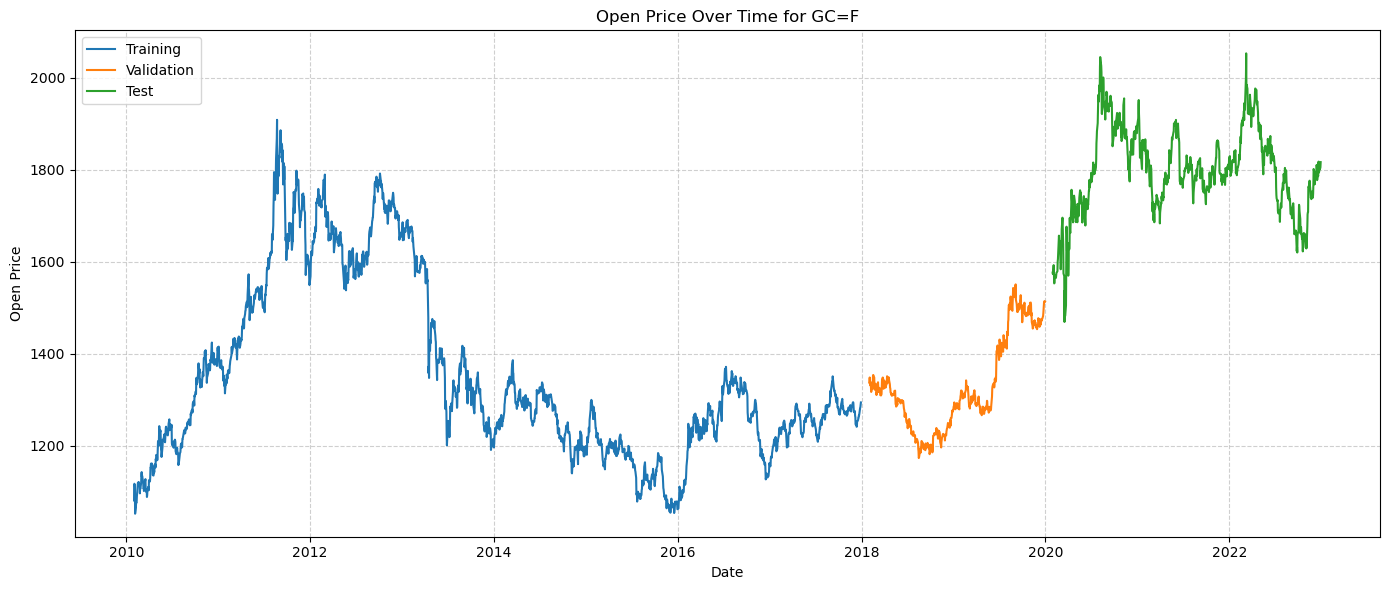

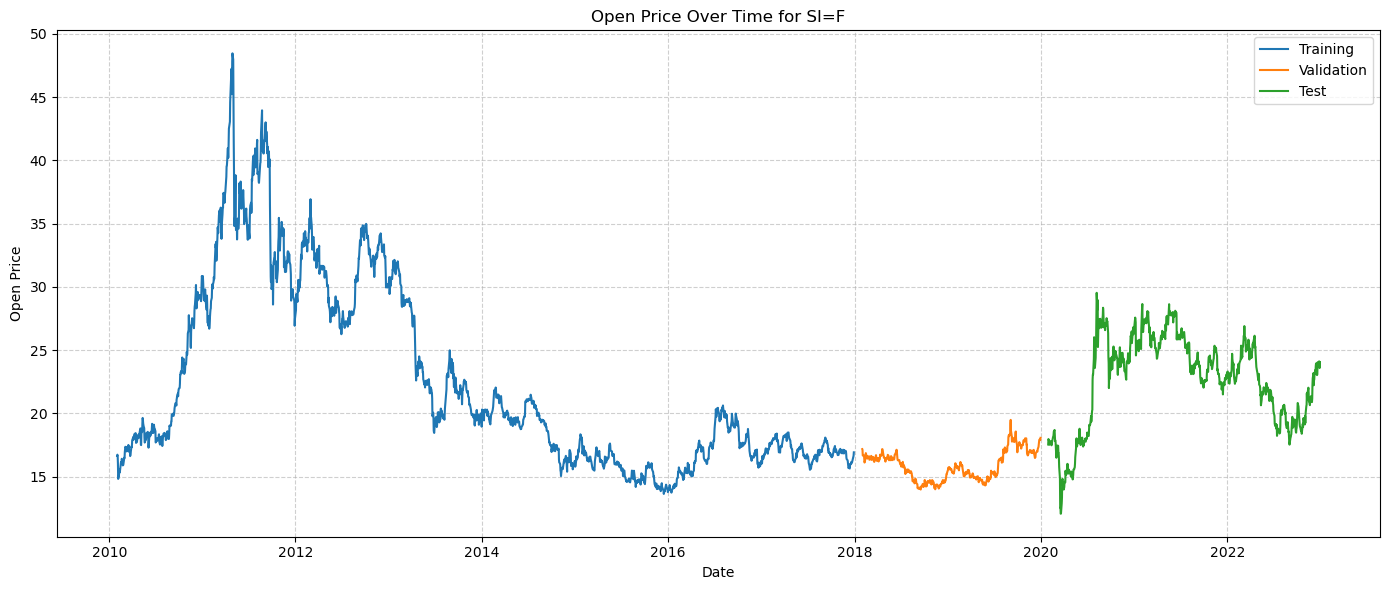

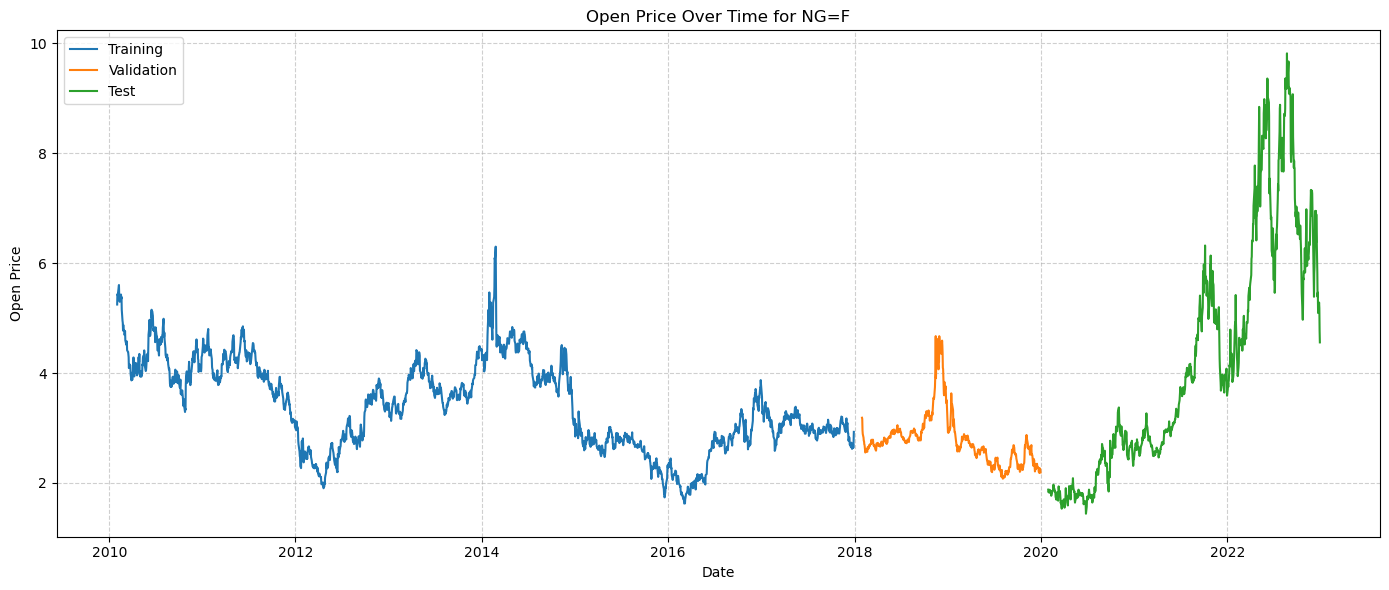

In [4]:
def plot_open_price(tickers, training_data, validation_data, test_data):

    if isinstance(tickers, str):
        tickers = [tickers]
    
    for ticker in tickers:
        plt.figure(figsize=(14, 6))

        plt.plot(training_data[ticker]['Open'], label='Training', color='#1f77b4')  
        plt.plot(validation_data[ticker]['Open'], label='Validation', color='#ff7f0e') 
        plt.plot(test_data[ticker]['Open'], label='Test', color='#2ca02c')      

        plt.title(f'Open Price Over Time for {ticker}')
        plt.xlabel('Date')
        plt.ylabel('Open Price')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

plot_open_price(['GC=F', 'SI=F', 'NG=F'], training_data, validation_data, test_data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


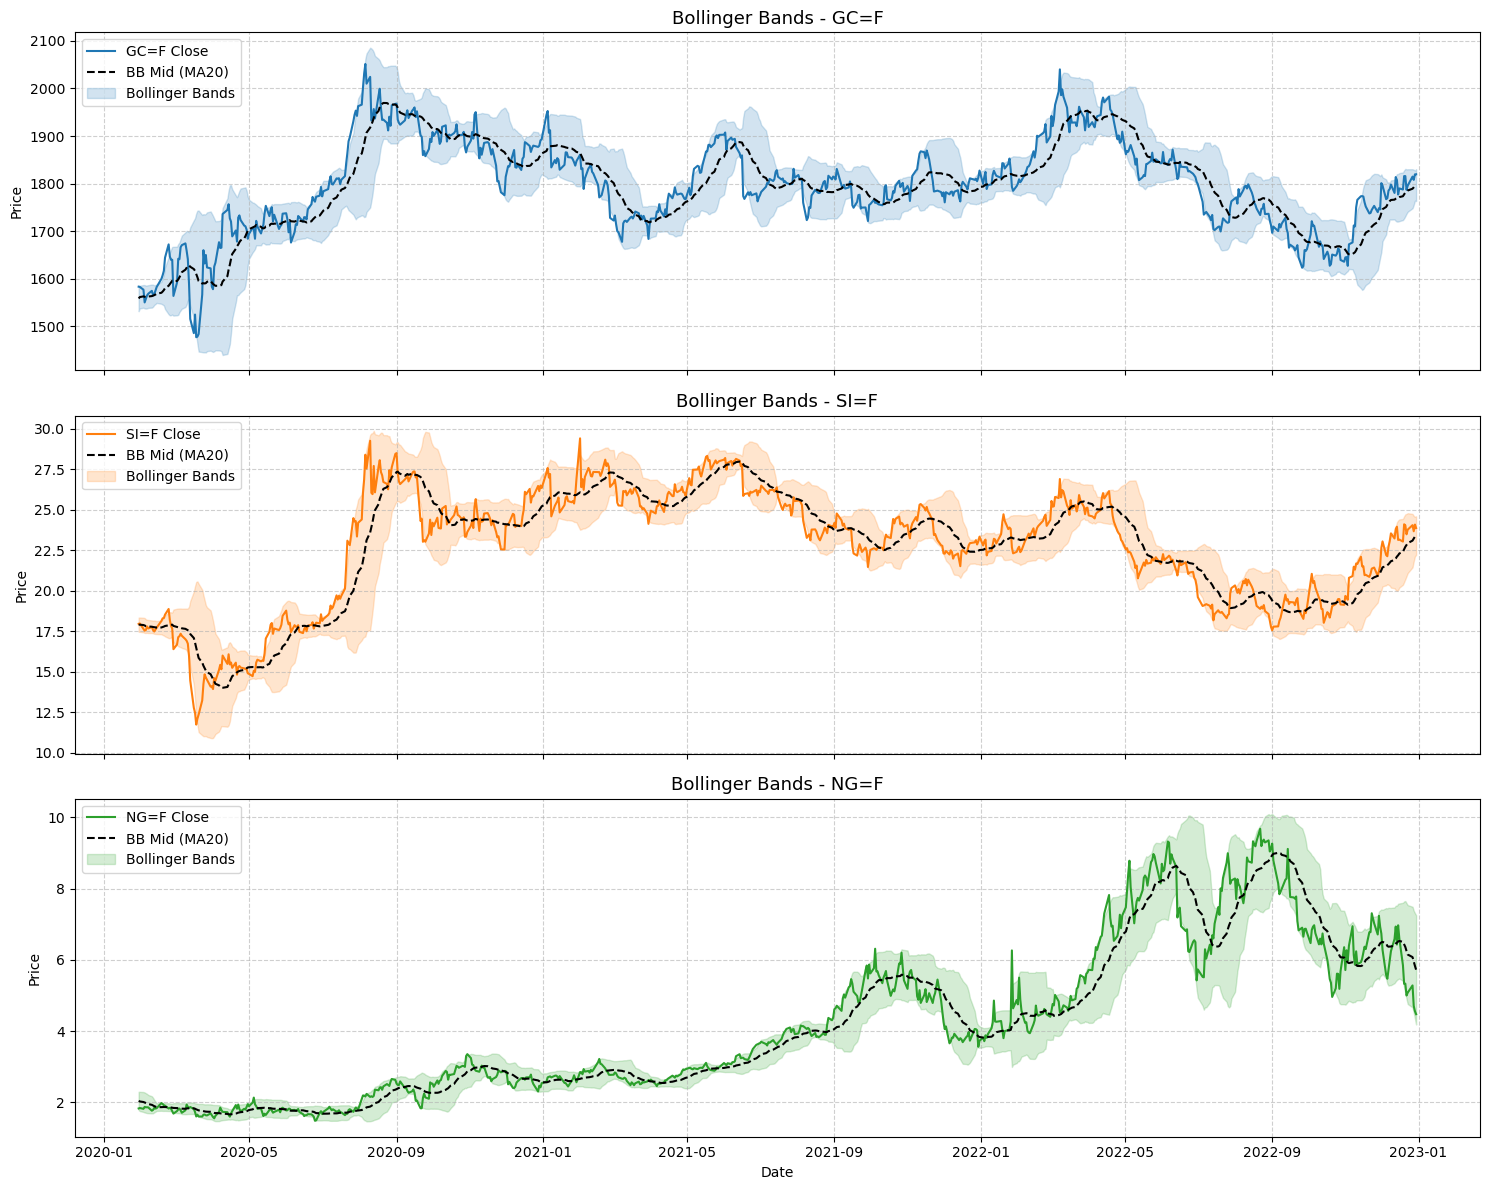

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Téléchargement des données
commodities = ['GC=F', 'SI=F', 'NG=F']
def get_commodities_data(tickers, start="2020-01-01", end="2023-01-01", interval="1d"):
    data = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end, interval=interval)
        data[ticker] = df
    return data

commodities_data = get_commodities_data(commodities)

# Fonction pour ajouter les bandes de Bollinger
def add_bollinger_bands(df, window=20):
    df = df.copy()
    df['BB_Mid'] = df['Close'].rolling(window=window).mean()
    df['BB_Std'] = df['Close'].rolling(window=window).std()
    df['BB_Upper'] = df['BB_Mid'] + 2 * df['BB_Std']
    df['BB_Lower'] = df['BB_Mid'] - 2 * df['BB_Std']
    return df.dropna()

# Ajout des indicateurs
for ticker in commodities:
    commodities_data[ticker] = add_bollinger_bands(commodities_data[ticker])

# Affichage
fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, ticker in enumerate(commodities):
    df = commodities_data[ticker]
    axs[i].plot(df.index, df['Close'], label=f"{ticker} Close", color=colors[i])
    axs[i].plot(df.index, df['BB_Mid'], label='BB Mid (MA20)', color='black', linestyle='--')
    axs[i].fill_between(df.index, df['BB_Upper'], df['BB_Lower'], color=colors[i], alpha=0.2, label='Bollinger Bands')

    axs[i].set_title(f"Bollinger Bands - {ticker}", fontsize=13)
    axs[i].set_ylabel("Price")
    axs[i].legend(loc='upper left')
    axs[i].grid(True, linestyle='--', alpha=0.6)

axs[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()


In [6]:
class CommodityTradingEnv(gym.Env):
    metadata = {'render_modes': ['human']}
    
    def __init__(self, commodity_data, transaction_cost_percent=0.005, initial_balance=10000):
        super(CommodityTradingEnv, self).__init__()
        
        self.commodity_data = {ticker: df for ticker, df in commodity_data.items() if not df.empty}
        self.tickers = list(self.commodity_data.keys())
        if not self.tickers:
            raise ValueError("Aucune donnée disponible pour les commodities.")
        
        sample_df = next(iter(self.commodity_data.values()))
        self.n_features = len(sample_df.columns)

        self.recent_actions = {ticker: [] for ticker in self.tickers} 
        
        # Espace d'actions discret (inchangé)
        self.action_list = [-1, -0.75, -0.50, -0.25, 0, 0.25, 0.50, 0.75, 1]
        self.num_actions_per_commodity = len(self.action_list)
        self.action_space = spaces.Discrete(self.num_actions_per_commodity ** len(self.tickers))
        
        # Espace d'observation
        self.obs_shape = self.n_features * len(self.tickers) + 2 + len(self.tickers) + 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_shape,), dtype=np.float32)
        
        self.initial_balance = initial_balance 
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
        self.total_sales_value = {ticker: 0 for ticker in self.tickers}
        
        self.current_step = 0
        self.max_steps = max(0, min(len(df) for df in self.commodity_data.values()) - 1)
        self.transaction_cost_percent = transaction_cost_percent
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
        self.total_sales_value = {ticker: 0 for ticker in self.tickers}
        self.current_step = 0
        return self._next_observation(), {}
    
    def _next_observation(self):
        frame = np.zeros(self.obs_shape)
        idx = 0
        for ticker in self.tickers:
            df = self.commodity_data[ticker]
            if self.current_step < len(df):
                frame[idx:idx+self.n_features] = df.iloc[self.current_step].values
            else:
                frame[idx:idx+self.n_features] = df.iloc[-1].values
            idx += self.n_features
        
        # Ajout des informations supplémentaires
        frame[-4-len(self.tickers)] = self.balance
        frame[-3-len(self.tickers):-3] = [self.shares_held[ticker] for ticker in self.tickers]
        frame[-3] = self.net_worth
        frame[-2] = self.max_net_worth
        frame[-1] = self.current_step
        
        return frame
    
    def decode_action(self, action):
        decoded_indices = []
        temp = action
        n = len(self.tickers)
        for _ in range(n):
            decoded_indices.append(temp % self.num_actions_per_commodity)
            temp //= self.num_actions_per_commodity
        decoded_indices.reverse()
        decoded_actions = [self.action_list[idx] for idx in decoded_indices]
        return decoded_actions
    
    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action[0])
        actions = self.decode_action(action)
        
        prev_net_worth = self.net_worth
        self.current_step += 1
        if self.current_step > self.max_steps:
            return self._next_observation(), 0, True, False, {}

        penalty = 0
        current_prices = {}

        for i, ticker in enumerate(self.tickers):
            price = float(self.commodity_data[ticker]['Close'].iloc[self.current_step])
            act = actions[i]
            current_prices[ticker] = price

            # Ajout de l'action actuelle à l'historique
            self.recent_actions[ticker].append(act)
            if len(self.recent_actions[ticker]) > 15:
                self.recent_actions[ticker].pop(0)

            if act < 0 and self.shares_held[ticker] <= 0:
                penalty -= 0.05

            # --- EXÉCUTION DES ACTIONS ---
            if act > 0:  # Achat
                shares_to_buy = int(self.balance * act / price)
                cost = shares_to_buy * price
                transaction_cost = cost * self.transaction_cost_percent
                self.balance -= (cost + transaction_cost)
                self.shares_held[ticker] += shares_to_buy

            elif act < 0 and self.shares_held[ticker] > 0:  # Vente
                shares_to_sell = int(self.shares_held[ticker] * abs(act))
                sale = shares_to_sell * price
                transaction_cost = sale * self.transaction_cost_percent
                self.balance += (sale - transaction_cost)
                self.shares_held[ticker] -= shares_to_sell
                self.total_shares_sold[ticker] += shares_to_sell
                self.total_sales_value[ticker] += sale

        self.net_worth = self.balance + sum(self.shares_held[ticker] * current_prices[ticker] for ticker in self.tickers)
        self.max_net_worth = max(self.net_worth, self.max_net_worth)
        reward = (self.net_worth - prev_net_worth) / prev_net_worth + penalty


        


        done = self.net_worth <= 0 or self.current_step >= self.max_steps
        return self._next_observation(), reward, done, False, {}
    
    def render(self, mode='human'):
        profit = self.net_worth - self.initial_balance
        print(f"Step: {self.current_step}")
        print(f"Balance: {self.balance:.2f}")
        for ticker in self.tickers:
            print(f"{ticker} Shares held: {self.shares_held[ticker]}")
        print(f"Net worth: {self.net_worth:.2f} | Profit: {profit:.2f}")
    
    def close(self):
        pass

In [7]:
import random
from collections import deque

class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.float32)
        )

    def __len__(self):
        return len(self.buffer)

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.model(x)

class MyDoubleDQN:
    def __init__(
        self,
        policy,  # pour compatibilité avec l'API SB3, non utilisé
        env,
        learning_rate=1e-5,
        buffer_size=100000,
        learning_starts=1000,
        batch_size=32,
        gamma=0.99,
        target_update_interval=1000,
        max_grad_norm=10,
        device="cpu",
        use_double_dqn=True,
        train_freq=1,
        gradient_steps=1,
        **kwargs
    ):
        # On récupère le premier environnement si env est un DummyVecEnv
        self.env = env.envs[0] if hasattr(env, "envs") else env
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        self.device = torch.device(device)
        self.lr = learning_rate
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_interval = target_update_interval
        self.learning_starts = learning_starts
        self.max_grad_norm = max_grad_norm
        self.use_double_dqn = use_double_dqn
        self.total_steps = 0

        # Ajout des paramètres de fréquence d'entraînement
        self.train_freq = train_freq
        self.gradient_steps = gradient_steps

        self.q_net = QNetwork(self.state_dim, self.action_dim).to(self.device)
        self.target_net = QNetwork(self.state_dim, self.action_dim).to(self.device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.lr)

        self.replay_buffer = ReplayBuffer(capacity=buffer_size)
        self.update_target_network(hard=True)

    def predict(self, obs, state=None, episode_start=None, deterministic=True):
        if isinstance(obs, tuple):
            obs = obs[0]
        obs_tensor = torch.FloatTensor(obs).to(self.device)
        if len(obs_tensor.shape) == 1:
            obs_tensor = obs_tensor.unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_net(obs_tensor)
        action = torch.argmax(q_values, dim=1).item()
        return action, None

    def learn(self, total_timesteps, reset_num_timesteps=True, **kwargs):
        obs, _ = self.env.reset()
        done = False

        cumulative_train_reward = 0
        losses = []

        for _ in range(total_timesteps):
            self.total_steps += 1

            # ε-greedy exploration
            epsilon = max(0.05, 1.0 - self.total_steps / 50000)
            if np.random.rand() < epsilon:
                action = self.env.action_space.sample()
            else:
                action, _ = self.predict(obs)

            next_obs, reward, done, _, _ = self.env.step(action)
            self.replay_buffer.push(obs, action, reward, next_obs, done)
            obs = next_obs

            cumulative_train_reward += reward

            if done:
                obs, _ = self.env.reset()

            # Appliquer l'apprentissage selon train_freq et gradient_steps
            if len(self.replay_buffer) > self.learning_starts and self.total_steps % self.train_freq == 0:
                for _ in range(self.gradient_steps):
                    loss = self.train_step()
                    losses.append(loss)

            if self.total_steps % self.target_update_interval == 0:
                self.update_target_network()

        avg_loss = np.mean(losses) if losses else 0.0
        return cumulative_train_reward, avg_loss

    def train_step(self):
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        with torch.no_grad():
            if self.use_double_dqn:
                next_q = self.q_net(next_states)
                next_actions = next_q.argmax(dim=1, keepdim=True)
                next_q_target = self.target_net(next_states).gather(1, next_actions)
            else:
                next_q_target = self.target_net(next_states).max(1, keepdim=True)[0]

            target_q = rewards + (1 - dones) * self.gamma * next_q_target

        current_q = self.q_net(states).gather(1, actions)

        loss = nn.MSELoss()(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q_net.parameters(), self.max_grad_norm)
        self.optimizer.step()

        return loss.item()


    def update_target_network(self, hard=True):
        if hard:
            self.target_net.load_state_dict(self.q_net.state_dict())
        else:
            for target_param, param in zip(self.target_net.parameters(), self.q_net.parameters()):
                target_param.data.copy_(0.995 * target_param.data + 0.005 * param.data)

    def save(self, path):
        torch.save(self.q_net.state_dict(), path)

    @classmethod
    def load(cls, path, env, device="cpu", **kwargs):
        agent = cls(policy=None, env=env, device=device, **kwargs)
        agent.q_net.load_state_dict(torch.load(path, map_location=device))
        agent.update_target_network(hard=True)
        return agent

In [8]:
class BollingerDoubleDQN:
    def __init__(self, policy, env, learning_rate=1e-5, buffer_size=100000, learning_starts=1000,
                 batch_size=32, gamma=0.99, target_update_interval=1000, max_grad_norm=10,
                 device="cpu", use_double_dqn=True, train_freq=1, gradient_steps=1, **kwargs):
        self.env = env.envs[0] if hasattr(env, "envs") else env
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        self.device = torch.device(device)
        self.lr = learning_rate
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_interval = target_update_interval
        self.learning_starts = learning_starts
        self.max_grad_norm = max_grad_norm
        self.use_double_dqn = use_double_dqn
        self.total_steps = 0

        self.train_freq = train_freq
        self.gradient_steps = gradient_steps

        self.q_net = QNetwork(self.state_dim, self.action_dim).to(self.device)
        self.target_net = QNetwork(self.state_dim, self.action_dim).to(self.device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.lr)

        self.replay_buffer = ReplayBuffer(capacity=buffer_size)
        self.update_target_network(hard=True)

    def predict(self, obs, state=None, episode_start=None, deterministic=True):
        if isinstance(obs, tuple):
            obs = obs[0]
        obs_tensor = torch.FloatTensor(obs).to(self.device)
        if len(obs_tensor.shape) == 1:
            obs_tensor = obs_tensor.unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_net(obs_tensor)
        action = torch.argmax(q_values, dim=1).item()
        return action, None
    
    def train_step(self):
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        with torch.no_grad():
            if self.use_double_dqn:
                next_q = self.q_net(next_states)
                next_actions = next_q.argmax(dim=1, keepdim=True)
                next_q_target = self.target_net(next_states).gather(1, next_actions)
            else:
                next_q_target = self.target_net(next_states).max(1, keepdim=True)[0]

            target_q = rewards + (1 - dones) * self.gamma * next_q_target

        current_q = self.q_net(states).gather(1, actions)

        loss = nn.MSELoss()(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q_net.parameters(), self.max_grad_norm)
        self.optimizer.step()

        return loss.item()

    def learn(self, total_timesteps, reset_num_timesteps=True, **kwargs):
        obs, _ = self.env.reset()
        done = False

        cumulative_train_reward = 0
        losses = []

        for _ in range(total_timesteps):
            self.total_steps += 1

            epsilon = max(0.05, 1.0 - self.total_steps / 50000)
            # print(f"Epsilon {epsilon}")
            if np.random.rand() < epsilon:
                action = self.encode_bollinger_strategy(obs)
            else:
                action, _ = self.predict(obs)

            next_obs, reward, done, _, _ = self.env.step(action)
            self.replay_buffer.push(obs, action, reward, next_obs, done)
            obs = next_obs

            cumulative_train_reward += reward

            if done:
                obs, _ = self.env.reset()

            if len(self.replay_buffer) > self.learning_starts and self.total_steps % self.train_freq == 0:
                for _ in range(self.gradient_steps):
                    loss = self.train_step()
                    losses.append(loss)

            if self.total_steps % self.target_update_interval == 0:
                self.update_target_network()

        avg_loss = np.mean(losses) if losses else 0.0
        return cumulative_train_reward, avg_loss

    def encode_bollinger_strategy(self, obs):
        tickers = self.env.tickers
        n = len(tickers)
        n_features = self.env.n_features
        actions = []
        for i in range(n):
            idx = i * n_features
            close = obs[idx + 3]
            bb_upper = obs[idx + 12]
            bb_lower = obs[idx + 13]

            if close < bb_lower:
                actions.append(0.5)
            elif close > bb_upper:
                actions.append(-0.5)
            else:
                actions.append(0.0)

        return self.encode_action(actions)

    def encode_action(self, action_vector):
        def closest(val):
            return min(range(len(self.env.action_list)), key=lambda i: abs(val - self.env.action_list[i]))

        index = 0
        base = self.env.num_actions_per_commodity
        for val in action_vector:
            idx = closest(val)
            index = index * base + idx
        return index
    
    def update_target_network(self, hard=True):
        if hard:
            self.target_net.load_state_dict(self.q_net.state_dict())
        else:
            for target_param, param in zip(self.target_net.parameters(), self.q_net.parameters()):
                target_param.data.copy_(0.995 * target_param.data + 0.005 * param.data)

    def save(self, path):
        torch.save(self.q_net.state_dict(), path)

    @classmethod
    def load(cls, path, env, device="cpu", **kwargs):
        agent = cls(policy=None, env=env, device=device, **kwargs)
        agent.q_net.load_state_dict(torch.load(path, map_location=device))
        agent.update_target_network(hard=True)
        return agent


In [9]:
env_train = DummyVecEnv([lambda: CommodityTradingEnv(training_data, transaction_cost_percent=0.005)])
env_val = DummyVecEnv([lambda: CommodityTradingEnv(validation_data, transaction_cost_percent=0.005)])
env_test = DummyVecEnv([lambda: CommodityTradingEnv(test_data, transaction_cost_percent=0.005)])

In [18]:
model = BollingerDoubleDQN(
    "MlpPolicy", 
    env_train, 
    verbose=1, 
    device="cpu", 
    learning_rate=1e-4,
    buffer_size=100000,
    learning_starts=1000,
    batch_size=32,
    gamma=0.99,
    train_freq=4,           # Par exemple : un entraînement tous les 4 pas
    gradient_steps=1,       # Et 1 pas de gradient par fois
    target_update_interval=1000,
    max_grad_norm=10,
    use_double_dqn=True
)

best_val_reward = -np.inf
best_model_path = "best_dqn_model.zip"
num_epochs = 100
timesteps_per_epoch = 1000

train_losses = []
train_rewards = []
val_rewards = []

for epoch in tqdm(range(num_epochs), desc="Training"):
    print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")
    train_reward, train_loss = model.learn(total_timesteps=timesteps_per_epoch, reset_num_timesteps=False)
    train_rewards.append(train_reward)
    train_losses.append(train_loss)

    print(f"Train Reward: {train_reward:.2f} | Train Loss: {train_loss:.4f}")

    # Évaluation sur l'environnement de validation (un épisode)
    val_obs = env_val.reset()
    done = False
    cumulative_reward = 0

    while not done:
        action, _ = model.predict(val_obs)
        val_obs, reward, done, info = env_val.step([action])
        cumulative_reward += reward[0]

    val_rewards.append(cumulative_reward)
    print(f"Récompense cumulée sur validation : {cumulative_reward}")

    if cumulative_reward > best_val_reward:
        best_val_reward = cumulative_reward
        model.save(best_model_path)
        print(f"Nouveau meilleur modèle sauvegardé (reward = {best_val_reward})")

Training:   0%|          | 0/100 [00:00<?, ?it/s]


=== Epoch 1/100 ===


C:\Users\planc\AppData\Local\Temp\ipykernel_22016\2847975497.py:94: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(self.commodity_data[ticker]['Close'].iloc[self.current_step])


Train Reward: 0.26 | Train Loss: 0.0000
Récompense cumulée sur validation : 0.033560484647750854
Nouveau meilleur modèle sauvegardé (reward = 0.033560484647750854)

=== Epoch 2/100 ===
Train Reward: -1.82 | Train Loss: 121566.7469
Récompense cumulée sur validation : -67.47401428222656

=== Epoch 3/100 ===
Train Reward: -0.38 | Train Loss: 4455.1436
Récompense cumulée sur validation : -0.34775203466415405

=== Epoch 4/100 ===
Train Reward: -1.71 | Train Loss: 2040.1345
Récompense cumulée sur validation : -48.19983673095703

=== Epoch 5/100 ===
Train Reward: -4.62 | Train Loss: 1289.1503
Récompense cumulée sur validation : -48.19983673095703

=== Epoch 6/100 ===
Train Reward: -5.91 | Train Loss: 1836.0695
Récompense cumulée sur validation : -0.21256479620933533

=== Epoch 7/100 ===
Train Reward: -5.60 | Train Loss: 1270.7683
Récompense cumulée sur validation : -23.53892707824707

=== Epoch 8/100 ===
Train Reward: -3.84 | Train Loss: 1471.6877
Récompense cumulée sur validation : -48.19983

C:\Users\planc\AppData\Local\Temp\ipykernel_22016\2847975497.py:94: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(self.commodity_data[ticker]['Close'].iloc[self.current_step])



Récompense cumulée sur test : 0.17875084


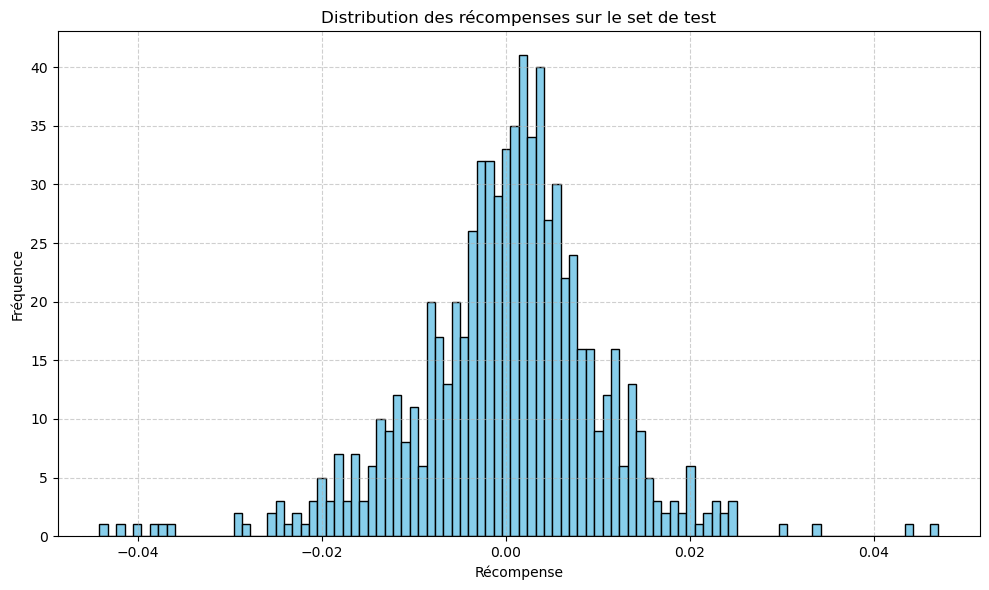

In [19]:
best_model = MyDoubleDQN.load(best_model_path, env=env_test, device="cpu")
obs = env_test.reset()
done = False
test_cumulative_reward = 0
rewards = []
while not done:
    action, _ = best_model.predict(obs)
    obs, reward, done, info = env_test.step([action])
    rewards.append(reward)
    test_cumulative_reward += reward[0]

def plot_reward_distribution(rewards):
    import matplotlib.pyplot as plt
    import numpy as np

    # Extraction des valeurs si reward est une liste de tableaux
    flattened_rewards = [r[0] if isinstance(r, (list, np.ndarray)) else r for r in rewards]

    plt.figure(figsize=(10, 6))
    plt.hist(flattened_rewards, bins=100, color='skyblue', edgecolor='black')
    plt.title("Distribution des récompenses sur le set de test")
    plt.xlabel("Récompense")
    plt.ylabel("Fréquence")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()



print("\nRécompense cumulée sur test :", test_cumulative_reward)
plot_reward_distribution(rewards=rewards)

C:\Users\planc\AppData\Local\Temp\ipykernel_22016\2847975497.py:94: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(self.commodity_data[ticker]['Close'].iloc[self.current_step])


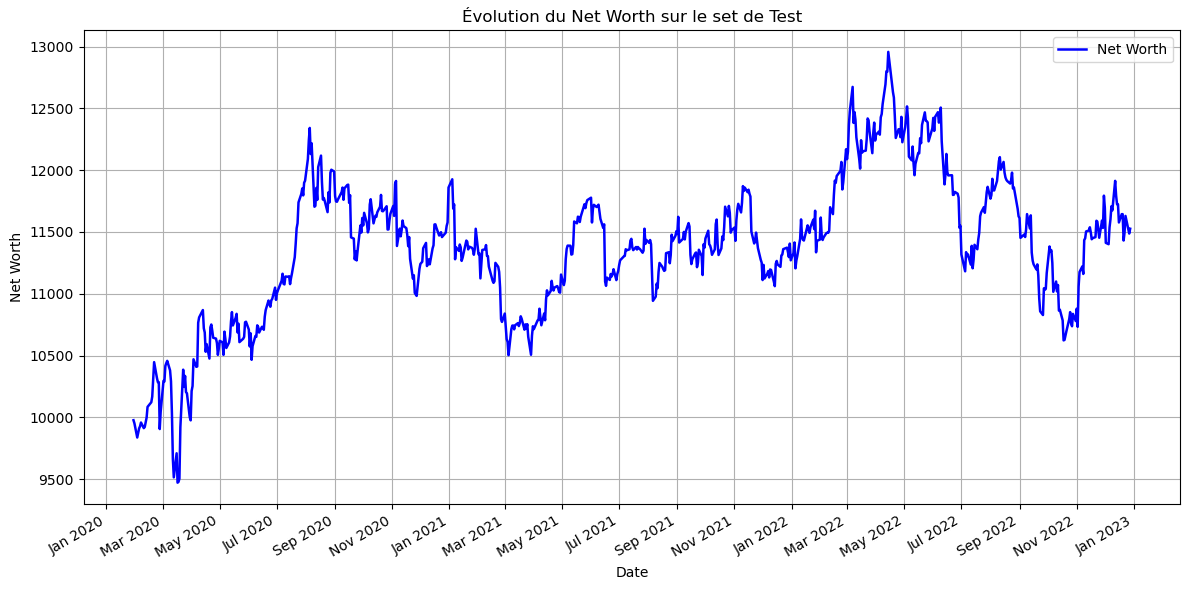

In [20]:
def test_agent(env, model, n_tests, visualize=False):
    metrics = {
        'steps': [],
        'balances': [],
        'net_worths': [],
        'shares_held': {ticker: [] for ticker in env.envs[0].commodity_data.keys()}
    }
    
    obs = env.reset()
    for i in range(n_tests):
        metrics['steps'].append(i)
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step([action])
        if visualize:
            env.envs[0].render()
        metrics['balances'].append(env.envs[0].balance)
        metrics['net_worths'].append(env.envs[0].net_worth)
        for ticker in env.envs[0].commodity_data.keys():
            metrics['shares_held'][ticker].append(env.envs[0].shares_held[ticker])
        if done:
            obs = env.reset()
    return metrics

max_days = env_test.envs[0].max_steps - 1
test_metrics = test_agent(env_test, best_model, n_tests=max_days, visualize=False)
import matplotlib.dates as mdates

def plot_net_worth(test_metrics, env):
    """
    Affiche l'évolution du Net Worth avec les dates réelles en abscisse.
    """
    # Récupération des dates depuis l'index du DataFrame (on prend le 1er ticker comme référence)
    df_index = env.envs[0].commodity_data[env.envs[0].tickers[0]].index
    
    # On aligne les dates avec la longueur des steps testés
    dates = df_index[:len(test_metrics['net_worths'])]

    plt.figure(figsize=(12,6))
    plt.plot(dates, test_metrics['net_worths'], label="Net Worth", color='blue', linewidth=1.8)
    plt.title("Évolution du Net Worth sur le set de Test")
    plt.xlabel("Date")
    plt.ylabel("Net Worth")
    plt.grid(True)
    plt.legend()

    # Formatage de la date en abscisse
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.show()

plot_net_worth(test_metrics=test_metrics, env=env_test)

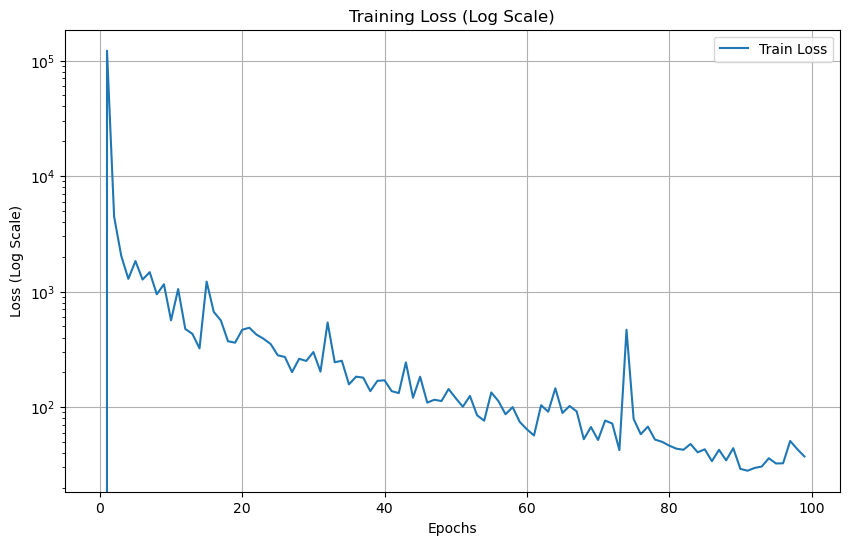

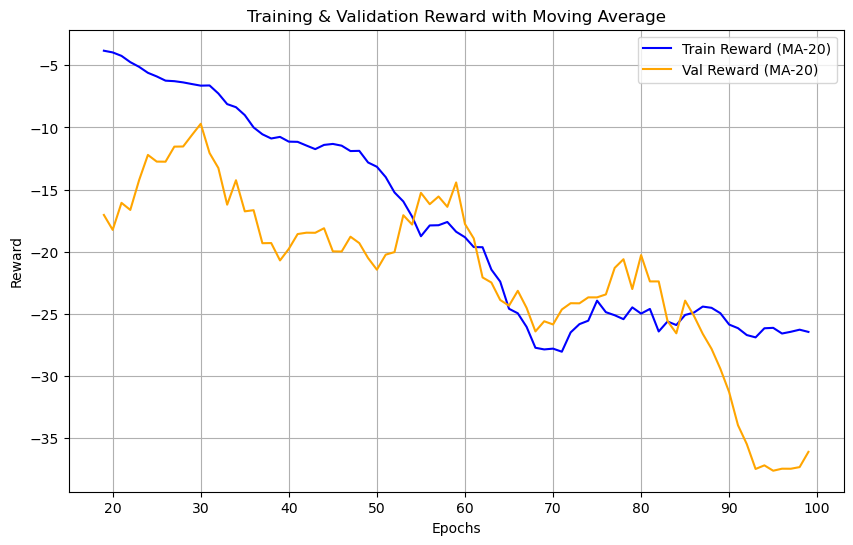

In [25]:
def plot_losses(epochs, train_losses):
    """
    Trace les courbes de pertes (loss) d'entraînement et de validation
    en fonction des epochs, avec une grille et des couleurs distinctes.
    L'axe des y est en échelle logarithmique.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.title("Training Loss (Log Scale)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (Log Scale)")
    plt.grid(True)
    plt.legend()
    
    # Mise à l'échelle logarithmique de l'axe des y
    plt.yscale('log')

def plot_rewards(epochs, train_rewards, val_rewards, window_size=10):
    """
    Trace les courbes de récompenses (train & validation) avec une moyenne mobile.
    
    Parameters:
    - epochs: Liste des epochs
    - train_rewards: Liste des récompenses d'entraînement
    - val_rewards: Liste des récompenses de validation
    - window_size: Taille de la fenêtre pour la moyenne mobile (par défaut 10)
    """
    # Calcul de la moyenne mobile (rolling mean)
    train_rewards_ma = pd.Series(train_rewards).rolling(window=window_size).mean()
    val_rewards_ma = pd.Series(val_rewards).rolling(window=window_size).mean()

    # Tracer les courbes avec les moyennes mobiles
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_rewards_ma, label=f'Train Reward (MA-{window_size})', color='blue')
    plt.plot(epochs, val_rewards_ma, label=f'Val Reward (MA-{window_size})', color='orange')
    plt.title("Training & Validation Reward with Moving Average")
    plt.xlabel("Epochs")
    plt.ylabel("Reward")
    plt.grid(True)
    plt.legend()
    plt.show()


# Supposons que tu as rempli train_losses, val_losses à chaque epoch
epochs_list = range(num_epochs)
plot_losses(epochs_list, train_losses)
plot_rewards(epochs_list, train_rewards, val_rewards, window_size=20)

C:\Users\planc\AppData\Local\Temp\ipykernel_22016\2847975497.py:94: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(self.commodity_data[ticker]['Close'].iloc[self.current_step])


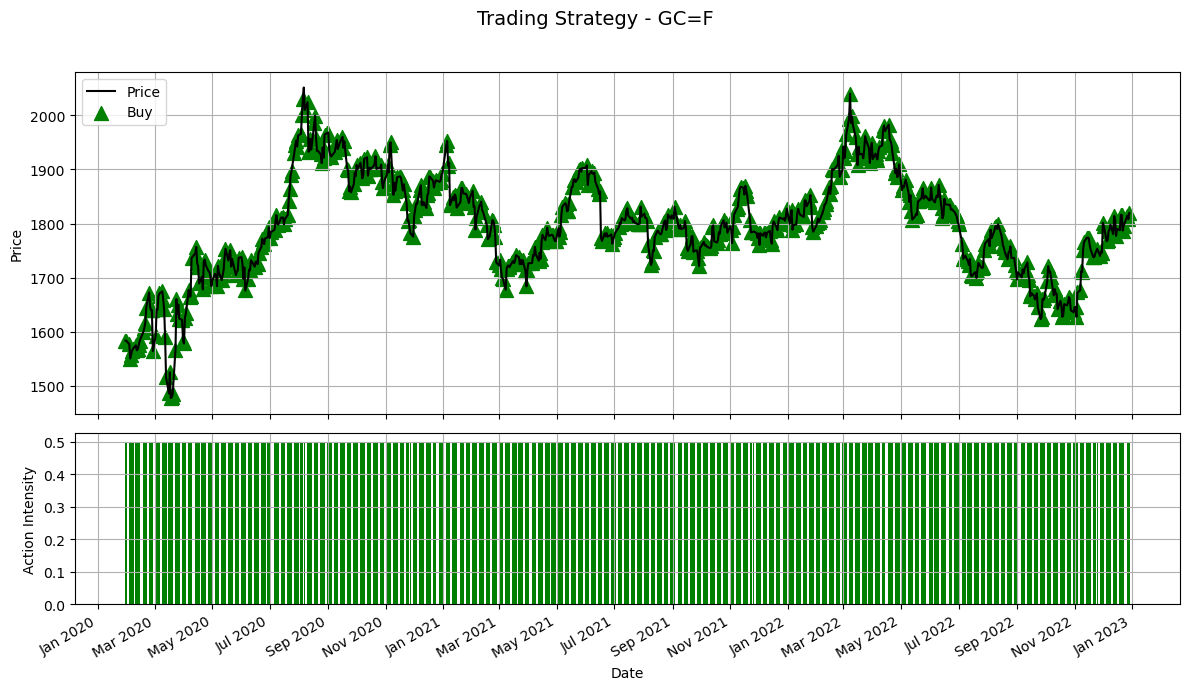

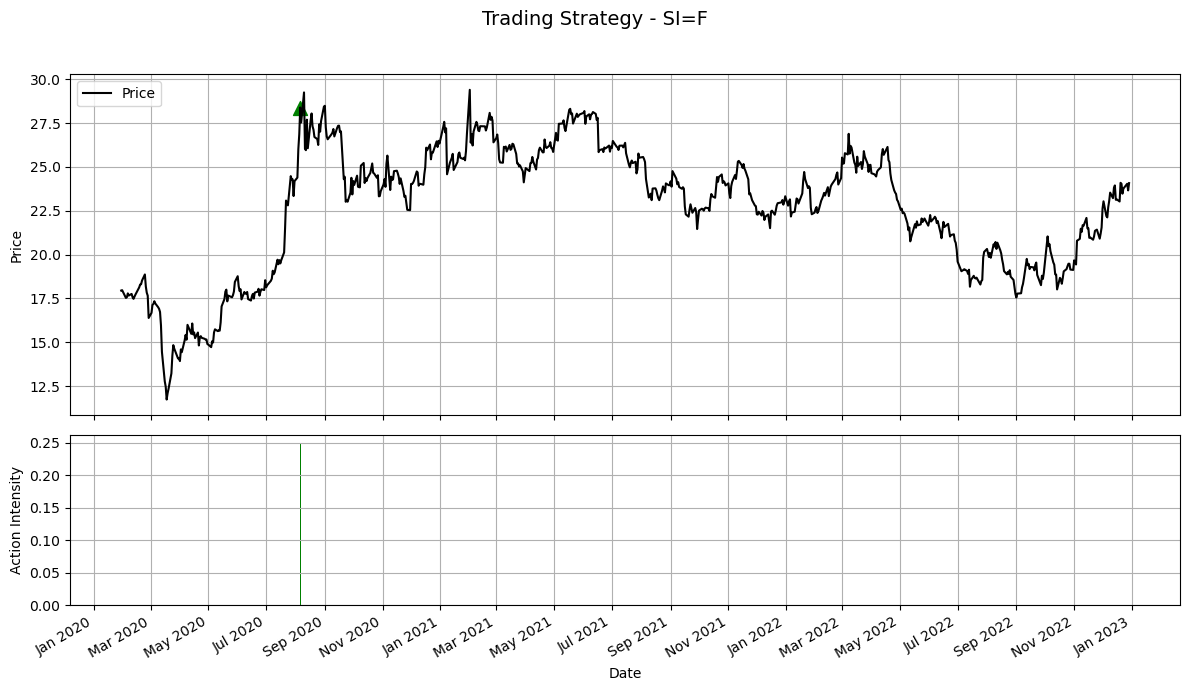

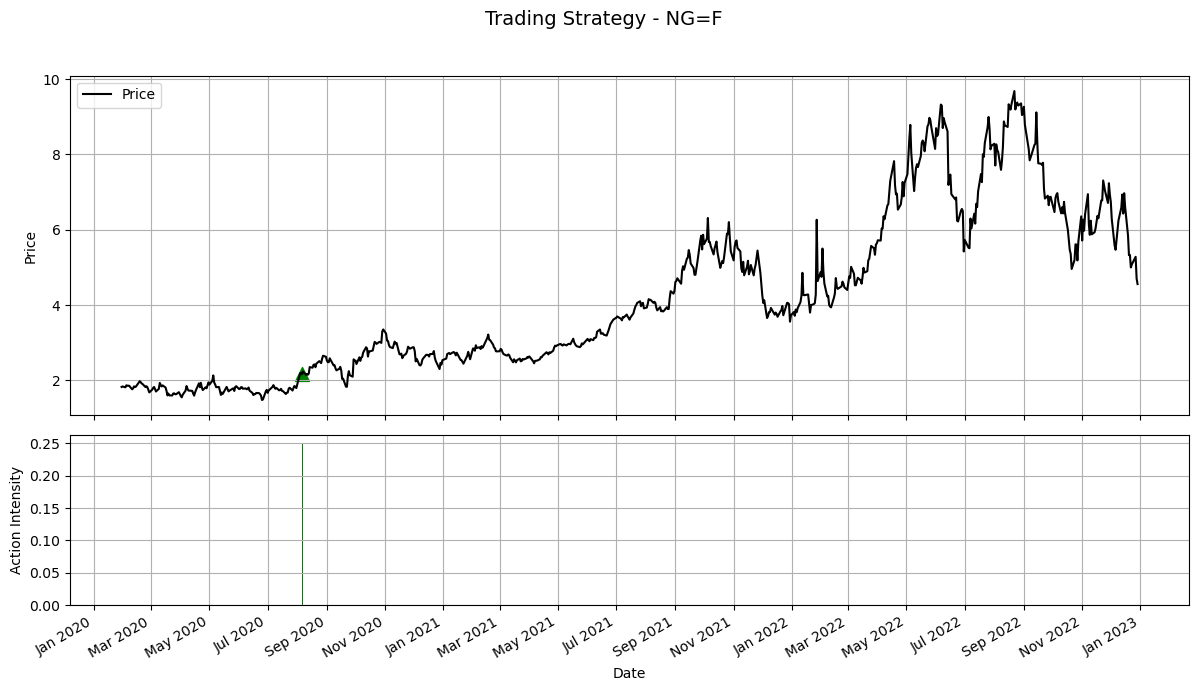

In [22]:
import matplotlib.dates as mdates

def plot_trading_strategy(env, model, n_steps=200):
    """
    Visualise la stratégie de trading pour chaque actif :
    - Courbe de prix avec markers achat/vente
    - Barres d'intensité (entre -1 et 1)
    - Axe x avec dates formatées (mois)
    """
    import matplotlib.pyplot as plt

    obs = env.reset()
    done = False
    step_count = 0

    price_history = {ticker: [] for ticker in env.envs[0].tickers}
    action_history = {ticker: [] for ticker in env.envs[0].tickers}
    date_history = []

    while not done and step_count < n_steps:
        step_count += 1
        action, _ = model.predict(obs)
        decoded_actions = env.envs[0].decode_action(action)

        current_step_in_env = env.envs[0].current_step
        date_index = env.envs[0].commodity_data[env.envs[0].tickers[0]].index[current_step_in_env]
        date_history.append(date_index)

        for i, ticker in enumerate(env.envs[0].tickers):
            price = env.envs[0].commodity_data[ticker]['Close'].iloc[current_step_in_env]
            price_history[ticker].append(price)
            action_history[ticker].append(decoded_actions[i])

        obs, reward, done, _ = env.step([action])

    for ticker in env.envs[0].tickers:
        fig, axs = plt.subplots(2, 1, figsize=(12, 7), sharex=True, height_ratios=[2, 1])
        fig.suptitle(f"Trading Strategy - {ticker}", fontsize=14)

        # -------- COURBE DE PRIX + MARKERS
        axs[0].plot(date_history, price_history[ticker], label="Price", color='black', linewidth=1.5)

        for i, act in enumerate(action_history[ticker]):
            if act > 0:
                axs[0].scatter(
                    date_history[i],
                    price_history[ticker][i],
                    marker='^',
                    color='green',
                    s=100,
                    label='Buy' if i == 0 else ""
                )
            elif act < 0:
                axs[0].scatter(
                    date_history[i],
                    price_history[ticker][i],
                    marker='v',
                    color='red',
                    s=100,
                    label='Sell' if i == 0 else ""
                )

        axs[0].set_ylabel("Price")
        axs[0].legend(loc='upper left')
        axs[0].grid(True)

        # -------- BARRES D'INTENSITÉ
        intensities = action_history[ticker]
        colors = ['green' if a > 0 else 'red' if a < 0 else 'gray' for a in intensities]
        axs[1].bar(date_history, intensities, color=colors, width=1)
        axs[1].set_ylabel("Action Intensity")
        axs[1].set_xlabel("Date")
        axs[1].grid(True)

        # -------- Formatage des dates
        axs[1].xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # tous les 2 mois
        axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # format 'Jan 2020'
        fig.autofmt_xdate()  # rotation auto

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

nb_days = env_test.envs[0].max_steps
plot_trading_strategy(env_test, best_model, n_steps=nb_days)
